# Data Mining Challange: *Reddit Gender Text-Classification* (MLP) 

### Modules

In [1]:
# Numpy & matplotlib for notebooks 
%pylab inline

# Pandas for data analysis and manipulation 
import pandas as pd 

# Sklearn 
from sklearn.preprocessing import StandardScaler # to standardize features by removing the mean and scaling to unit variance (z=(x-u)/s)
from sklearn.neural_network import MLPClassifier # Multi-layer Perceptron classifier which optimizes the log-loss function using LBFGS or sdg.
from sklearn.model_selection import train_test_split # to split arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold # K-Folds cross-validator providing train/test indices to split data in train/test sets.
from sklearn.decomposition import PCA, TruncatedSVD # Principal component analysis (PCA); dimensionality reduction using truncated SVD.
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB # Naive Bayes classifier for multinomial models
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts
from sklearn.metrics import roc_auc_score as roc # Compute Area Under the Receiver Operating Characteristic Curve from prediction scores
from sklearn.metrics import roc_curve, auc # Compute ROC; Compute Area Under the Curve (AUC) using the trapezoidal rule

# Matplotlib
import matplotlib # Data visualization
import matplotlib.pyplot as plt 
import matplotlib.patches as mpatches  

# Seaborn
import seaborn as sns # Statistical data visualization (based on matplotlib)

Populating the interactive namespace from numpy and matplotlib


### Data Collection 

In [2]:
# Import the training dataset and target. Create a list of authors

# Import the training dataset
train_data = pd.read_csv("../input/dataset/train_data.csv", encoding="utf8") 

# Import the training target
train_target = pd.read_csv("../input/dataset/train_target.csv") 

# Create author's gender dictionary
author_gender = {}

# Populate the dictionary with keys ("authors") and values ("gender")
for i in range(len(target)):
    author_gender[target.author[i]] = target.gender[i]

### Data Manipulation

In [4]:
# Create a list of aggregated binary subreddits 
Xs = []
# Create a list of genders
y = []
# Create a list of authors
a = []

# Populate the lists 
for author, group in train_data.groupby("author"):
    Xs.append(group.subreddit.str.cat(sep = " "))
    y.append(author_gender[author])
    a.append(author)

# Lower text in comments 
clean_train_subreddits = [xs.lower() for xs in Xs]

### Models Definition & Training

#### CountVectorizer

In [ ]:
# Define CountVectorizer  
vectorizer_ = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,
                             binary=True
                             ) #500
# Train CountVectorizer  
train_data_subreddits = vectorizer_.fit_transform(clean_train_subreddits).toarray()

sum(train_data_subreddits[1])

y = np.array(y)

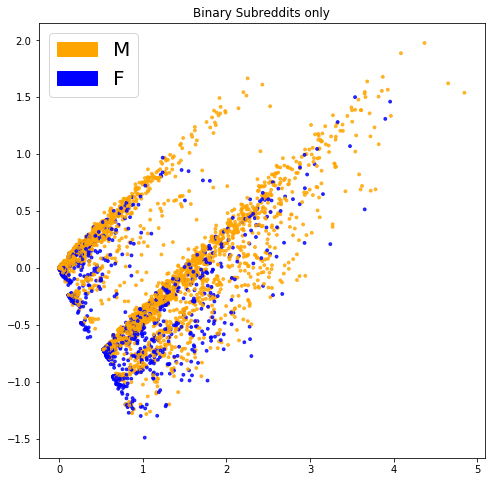

In [34]:
# Plot the test data along the 2 dimensions of largest variance
def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='M')
            blue_patch = mpatches.Patch(color='blue', label='F')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})
            plt.title('Binary Subreddits only')
            plt.savefig('foo.pdf')

plt.figure(figsize=(8, 8))
plot_LSA(train_data_subreddits, y)
plt.show()

#### MLP Classifier

In [11]:
# Split the data for training 
X_train, X_valid, y_train, y_valid = train_test_split(train_data_subreddits, y,
                                                      train_size=0.8, test_size=0.2,
                                                      random_state=0)

# Define MLP Classifier:
## Activation function for the hidden layer: "rectified linear unit function"
## Solver for weight optimization: "stochastic gradient-based optimizer"
## Alpha: regularization parameter
## Learning rate schedule for weight updates: "gradually decreases the learning rate at each time step t using an inverse scaling exponent of power_t"
## Verbose: "True" in order to print progress messages to stdout.
## Early stopping: "True" in order to use early stopping to terminate training when validation score is not improving. It automatically sets aside 10% of training data as validation and terminate training when validation score is not improving by at least tol for n_iter_no_change consecutive epochs.

mlpClf = MLPClassifier(activation= 'relu', solver = 'adam', 
                       alpha = 0.05, learning_rate = 'invscaling', verbose = True, 
                       early_stopping = True, max_iter = 400, random_state=0)

        
# K fold per la cross-validation
kf = KFold(n_splits = 8)

# Training and validation on all K folds
for train_indices, test_indices in kf.split(X_train):
    mlpClf.fit(X_train[train_indices], y_train[train_indices])
    print(mlpClf.score(X_train[test_indices], y_train[test_indices]))

Iteration 1, loss = 0.61256098
Validation score: 0.731429
Iteration 2, loss = 0.51463449
Validation score: 0.742857
Iteration 3, loss = 0.44105220
Validation score: 0.797143
Iteration 4, loss = 0.37871499
Validation score: 0.834286
Iteration 5, loss = 0.33365672
Validation score: 0.845714
Iteration 6, loss = 0.30174148
Validation score: 0.851429
Iteration 7, loss = 0.27820464
Validation score: 0.860000
Iteration 8, loss = 0.26028240
Validation score: 0.854286
Iteration 9, loss = 0.24678298
Validation score: 0.854286
Iteration 10, loss = 0.23516429
Validation score: 0.854286
Iteration 11, loss = 0.22590491
Validation score: 0.854286
Iteration 12, loss = 0.21771969
Validation score: 0.848571
Iteration 13, loss = 0.21126254
Validation score: 0.851429
Iteration 14, loss = 0.20535204
Validation score: 0.857143
Iteration 15, loss = 0.20062956
Validation score: 0.854286
Iteration 16, loss = 0.19606391
Validation score: 0.857143
Iteration 17, loss = 0.19187650
Validation score: 0.857143
Iterat

In [12]:
# Prediction
y_score = mlpClf.predict_proba(X_valid)[:,1]

In [13]:
# Display score
roc(y_valid,y_score)

0.9013054604029034

### ROC Visualization 

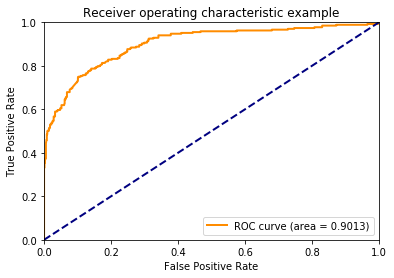

In [14]:
# ROC Curve for validation data 
fpr, tpr, thresholds = roc_curve(y_valid, y_score)
roc_auc = auc(fpr, tpr) 

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)'% roc_auc )

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [15]:
np.save("y_score_MLPs",y_score)